In [1]:
"""
Pytorch implementation of RGB convert to HSV, and HSV convert to RGB,
RGB or HSV's shape: (B * C * H * W)
RGB or HSV's range: [0, 1)
"""
import torch
from torch import nn

class RGB_HSV(nn.Module):
    def __init__(self, eps=1e-8):
        super(RGB_HSV, self).__init__()
        self.eps = eps

    def rgb_to_hsv(self, img):

        hue = torch.Tensor(img.shape[0], img.shape[2], img.shape[3]).to(img.device)

        hue[ img[:,2]==img.max(1)[0] ] = 4.0 + ( (img[:,0]-img[:,1]) / ( img.max(1)[0] - img.min(1)[0] + self.eps) ) [ img[:,2]==img.max(1)[0] ]
        hue[ img[:,1]==img.max(1)[0] ] = 2.0 + ( (img[:,2]-img[:,0]) / ( img.max(1)[0] - img.min(1)[0] + self.eps) ) [ img[:,1]==img.max(1)[0] ]
        hue[ img[:,0]==img.max(1)[0] ] = (0.0 + ( (img[:,1]-img[:,2]) / ( img.max(1)[0] - img.min(1)[0] + self.eps) ) [ img[:,0]==img.max(1)[0] ]) % 6

        hue[img.min(1)[0]==img.max(1)[0]] = 0.0
        hue = hue/6

        saturation = ( img.max(1)[0] - img.min(1)[0] ) / ( img.max(1)[0] + self.eps )
        saturation[ img.max(1)[0]==0 ] = 0

        value = img.max(1)[0]
        
        hue = hue.unsqueeze(1)
        saturation = saturation.unsqueeze(1)
        value = value.unsqueeze(1)
        hsv = torch.cat([hue, saturation, value],dim=1)
        return hsv

    def hsv_to_rgb(self, hsv):
        h,s,v = hsv[:,0,:,:],hsv[:,1,:,:],hsv[:,2,:,:]
        #对出界值的处理
        h = h%1
        s = torch.clamp(s,0,1)
        v = torch.clamp(v,0,1)
  
        r = torch.zeros_like(h)
        g = torch.zeros_like(h)
        b = torch.zeros_like(h)
        
        hi = torch.floor(h * 6)
        f = h * 6 - hi
        p = v * (1 - s)
        q = v * (1 - (f * s))
        t = v * (1 - ((1 - f) * s))
        
        hi0 = hi==0
        hi1 = hi==1
        hi2 = hi==2
        hi3 = hi==3
        hi4 = hi==4
        hi5 = hi==5
        
        r[hi0] = v[hi0]
        g[hi0] = t[hi0]
        b[hi0] = p[hi0]
        
        r[hi1] = q[hi1]
        g[hi1] = v[hi1]
        b[hi1] = p[hi1]
        
        r[hi2] = p[hi2]
        g[hi2] = v[hi2]
        b[hi2] = t[hi2]
        
        r[hi3] = p[hi3]
        g[hi3] = q[hi3]
        b[hi3] = v[hi3]
        
        r[hi4] = t[hi4]
        g[hi4] = p[hi4]
        b[hi4] = v[hi4]
        
        r[hi5] = v[hi5]
        g[hi5] = p[hi5]
        b[hi5] = q[hi5]
        
        r = r.unsqueeze(1)
        g = g.unsqueeze(1)
        b = b.unsqueeze(1)
        rgb = torch.cat([r, g, b], dim=1)
        return rgb

In [2]:
from torchvision.utils import save_image, make_grid
import torch
import os
import cv2
import matplotlib.pyplot as plt
# from rgb_hsv import RGB_HSV
import matplotlib.colors as mcolors

dir = '/SSD_DISK/users/chenjiaqi/data/nyudepthv2/train/student_lounge_0001/01571.h5'

import h5py
with h5py.File(dir, "r") as f:
    rgb = torch.tensor(f['rgb'])
    depth = torch.tensor(f['depth']).unsqueeze(0)
    

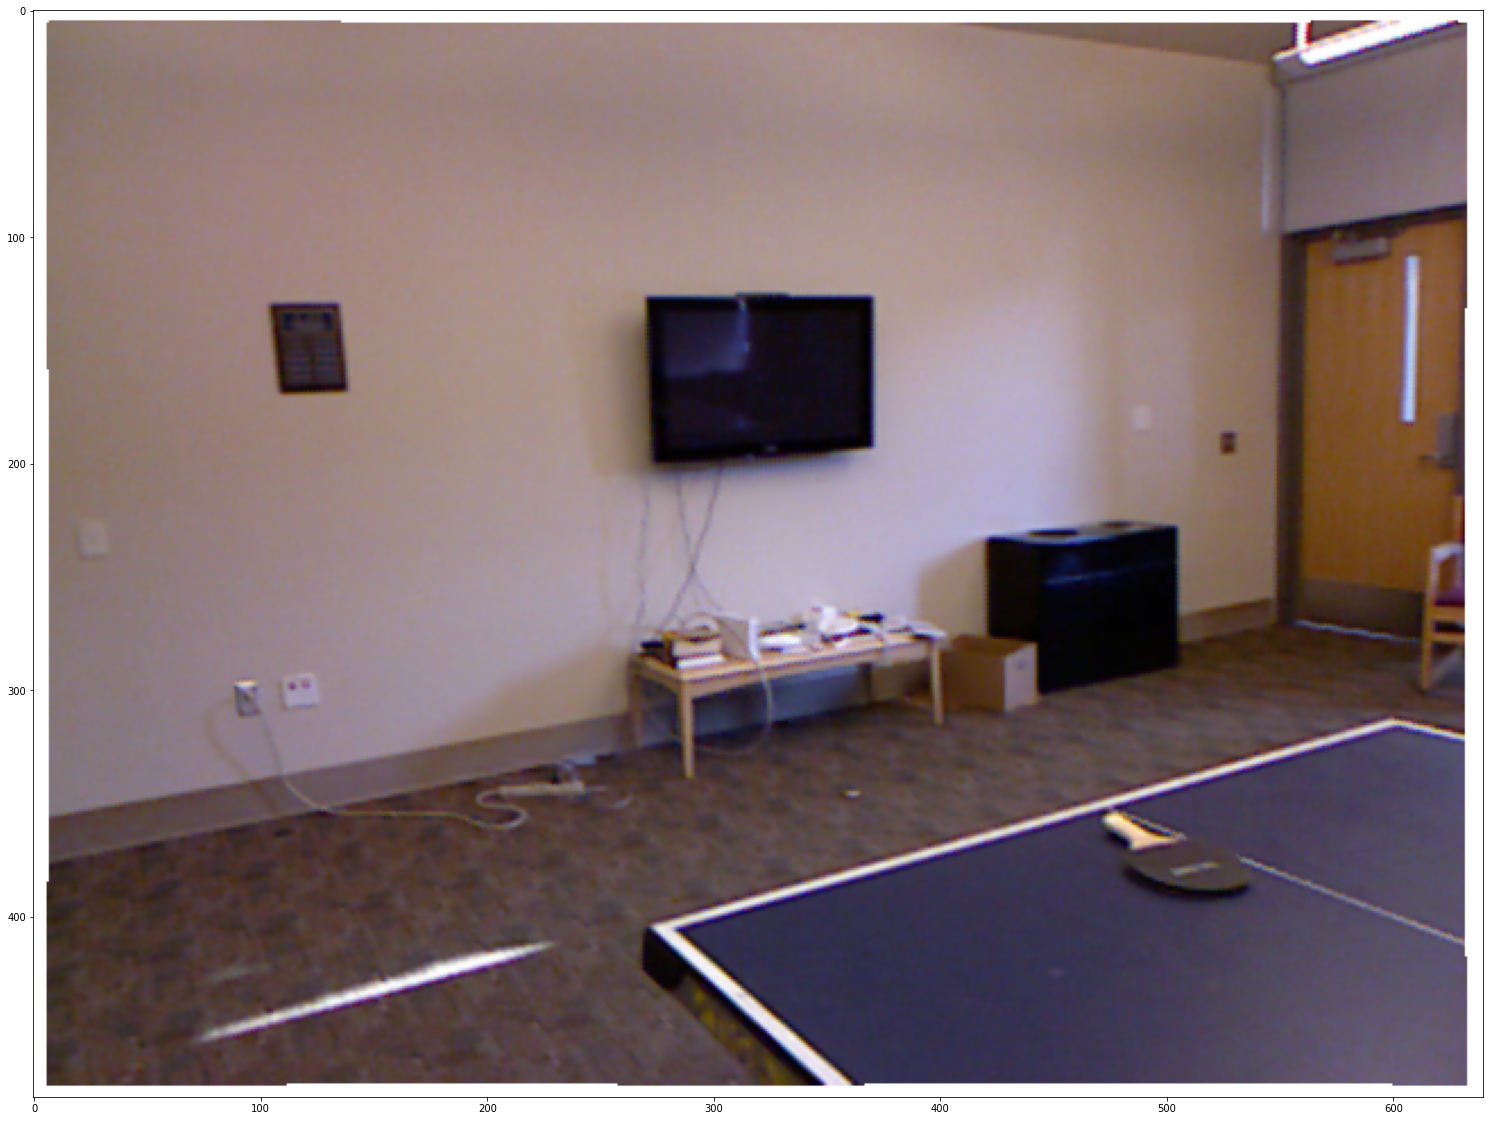

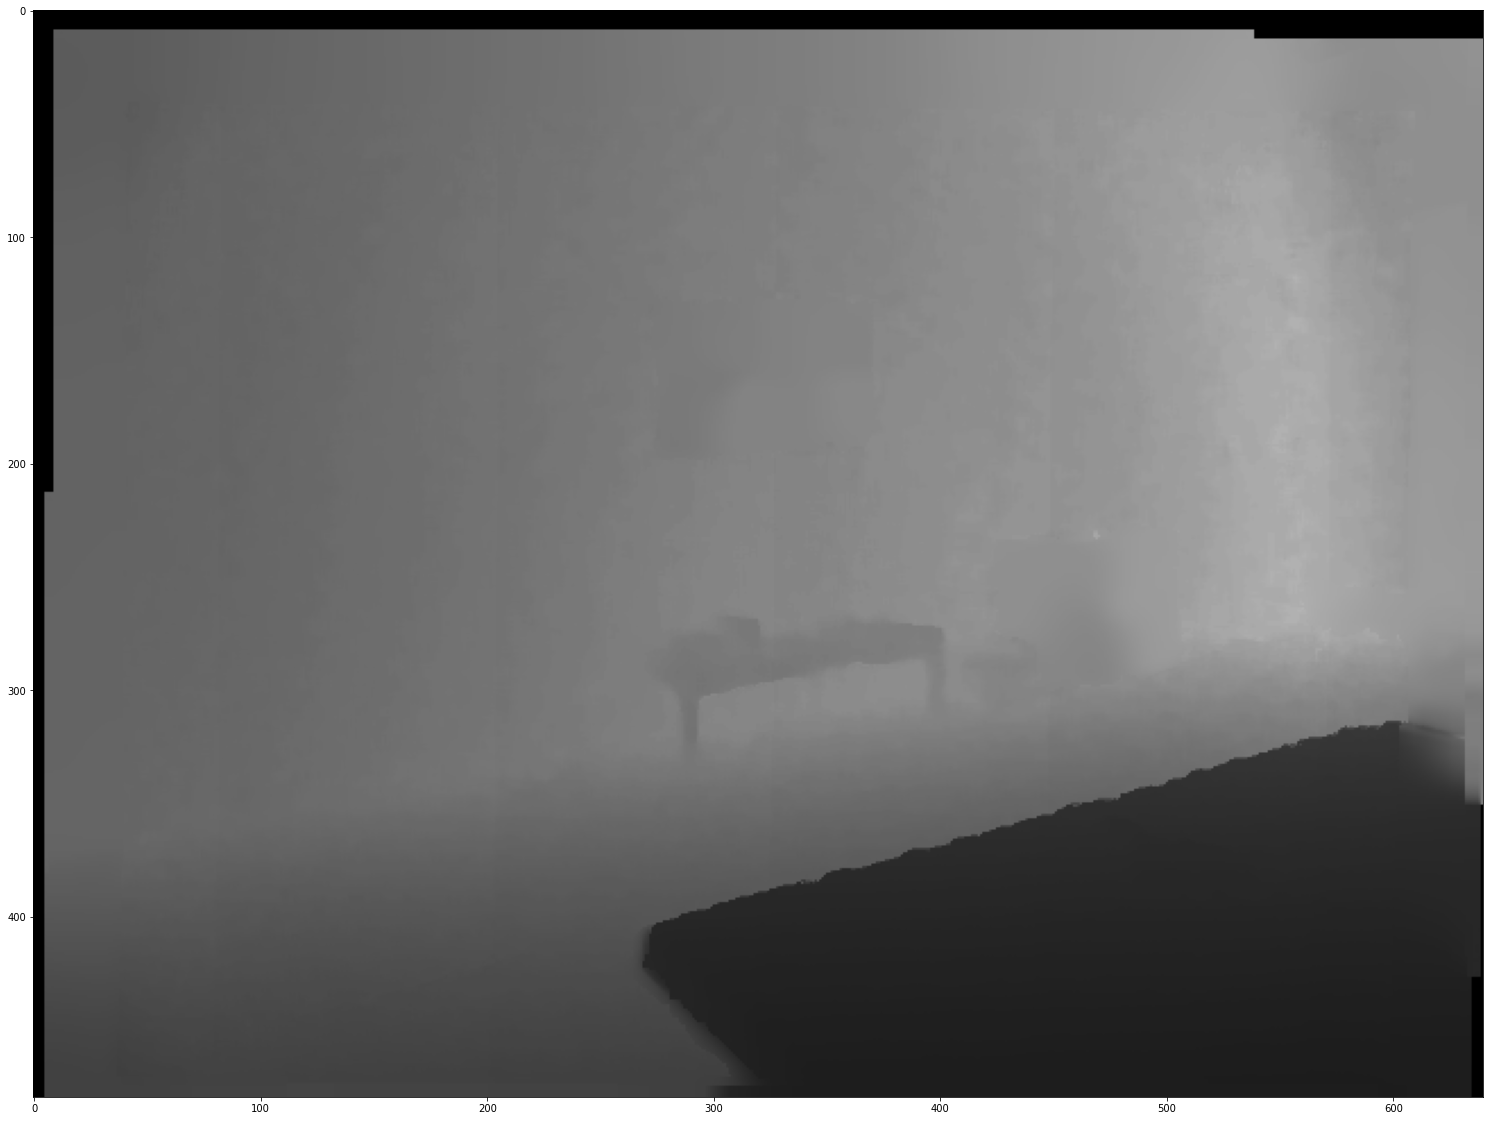

In [3]:
rgb_tensor = rgb.permute(1,2,0).float() / 255.0
depth_tensor = depth.permute(1, 2, 0)
depth_tensor = torch.cat([depth_tensor, depth_tensor, depth_tensor], dim=2) / 10.0
plt.figure(figsize=(30,20))
plt.imshow(rgb_tensor)

plt.figure(figsize=(30,20))
plt.imshow(depth_tensor)

# plt.figure(figsize=(30,20))
# plt.imshow(depth)




torch.Size([480, 640, 1])
torch.Size([1, 3, 480, 640])
torch.Size([1, 3, 480, 640])
torch.Size([480, 640])
torch.Size([480, 640, 1])
tensor(6.6701e-09)


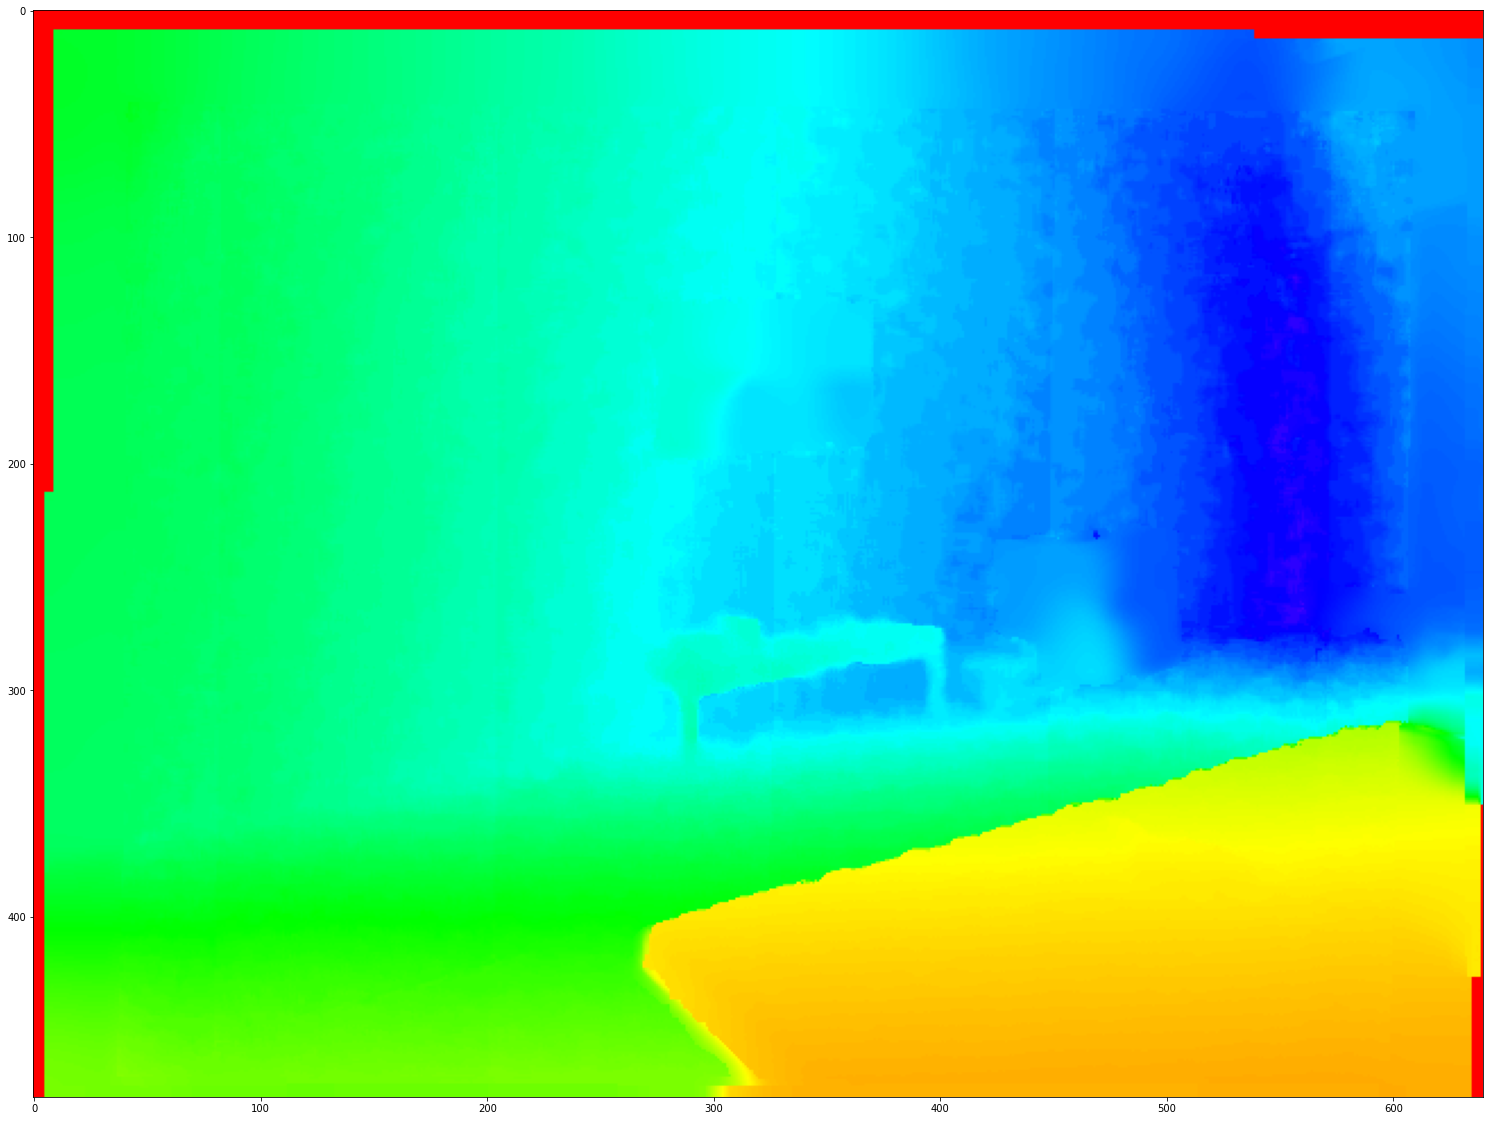

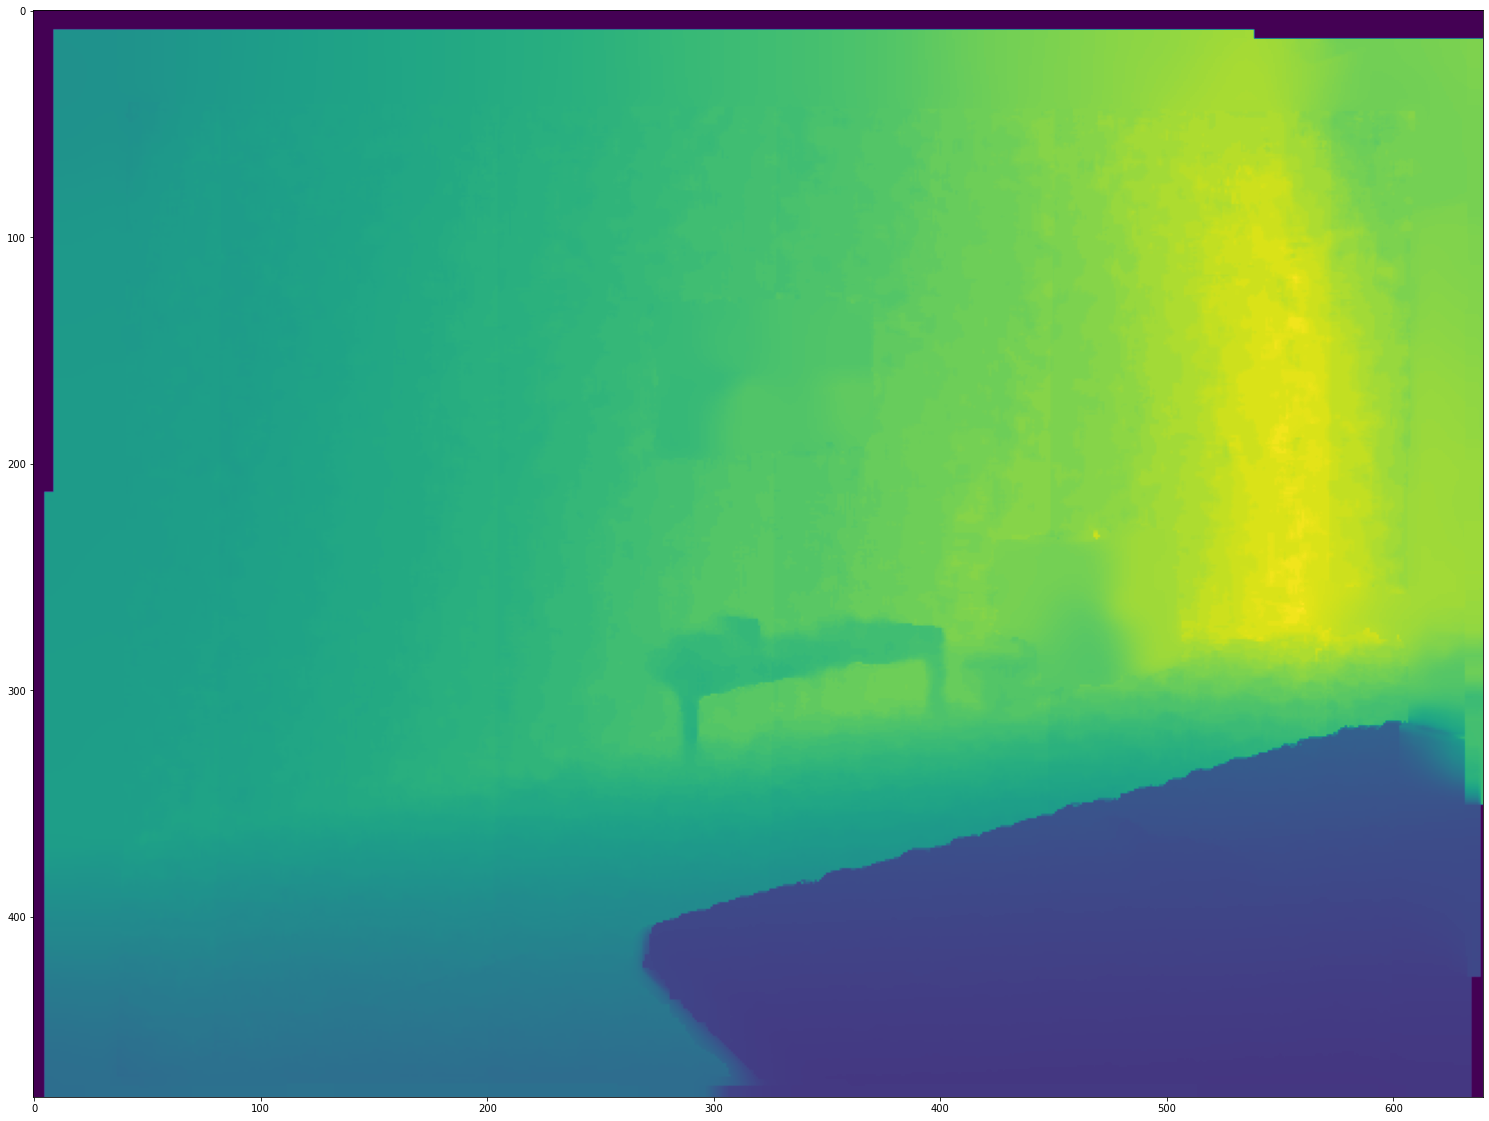

In [4]:
convertor = RGB_HSV()
# print(depth_tensor.shape)
# print(depth_tensor[:,:,1])
h = depth_tensor[:,:,:1]

print(h.shape)
s = torch.ones_like(h) * 1
v = torch.ones_like(h) * 1

hsv_tensor = torch.cat([h, s, v], dim=2)
# print(hsv_tensor.shape)
rgb_tensor = convertor.hsv_to_rgb(hsv_tensor.permute(2, 0, 1).unsqueeze(0))

plt.figure(figsize=(30,20))
plt.imshow(rgb_tensor[0].permute(1, 2, 0))
print(rgb_tensor.shape)
hsv_tensor_recon = convertor.rgb_to_hsv(rgb_tensor)
print(hsv_tensor_recon.shape)
plt.figure(figsize=(30,20))
recon_depth = hsv_tensor_recon[0].permute(1, 2, 0)[:,:,0]

plt.imshow(recon_depth)
print(recon_depth.shape)
print(depth_tensor[:,:,:1].shape)

m = torch.mean(torch.abs(recon_depth - depth_tensor[:,:,1]))

print(m)




torch.Size([480, 640, 1])
torch.Size([1, 3, 480, 640])
torch.Size([1, 3, 480, 640])
torch.Size([480, 640, 1])
torch.Size([480, 640, 1])


RuntimeError: The size of tensor a (640) must match the size of tensor b (480) at non-singleton dimension 1

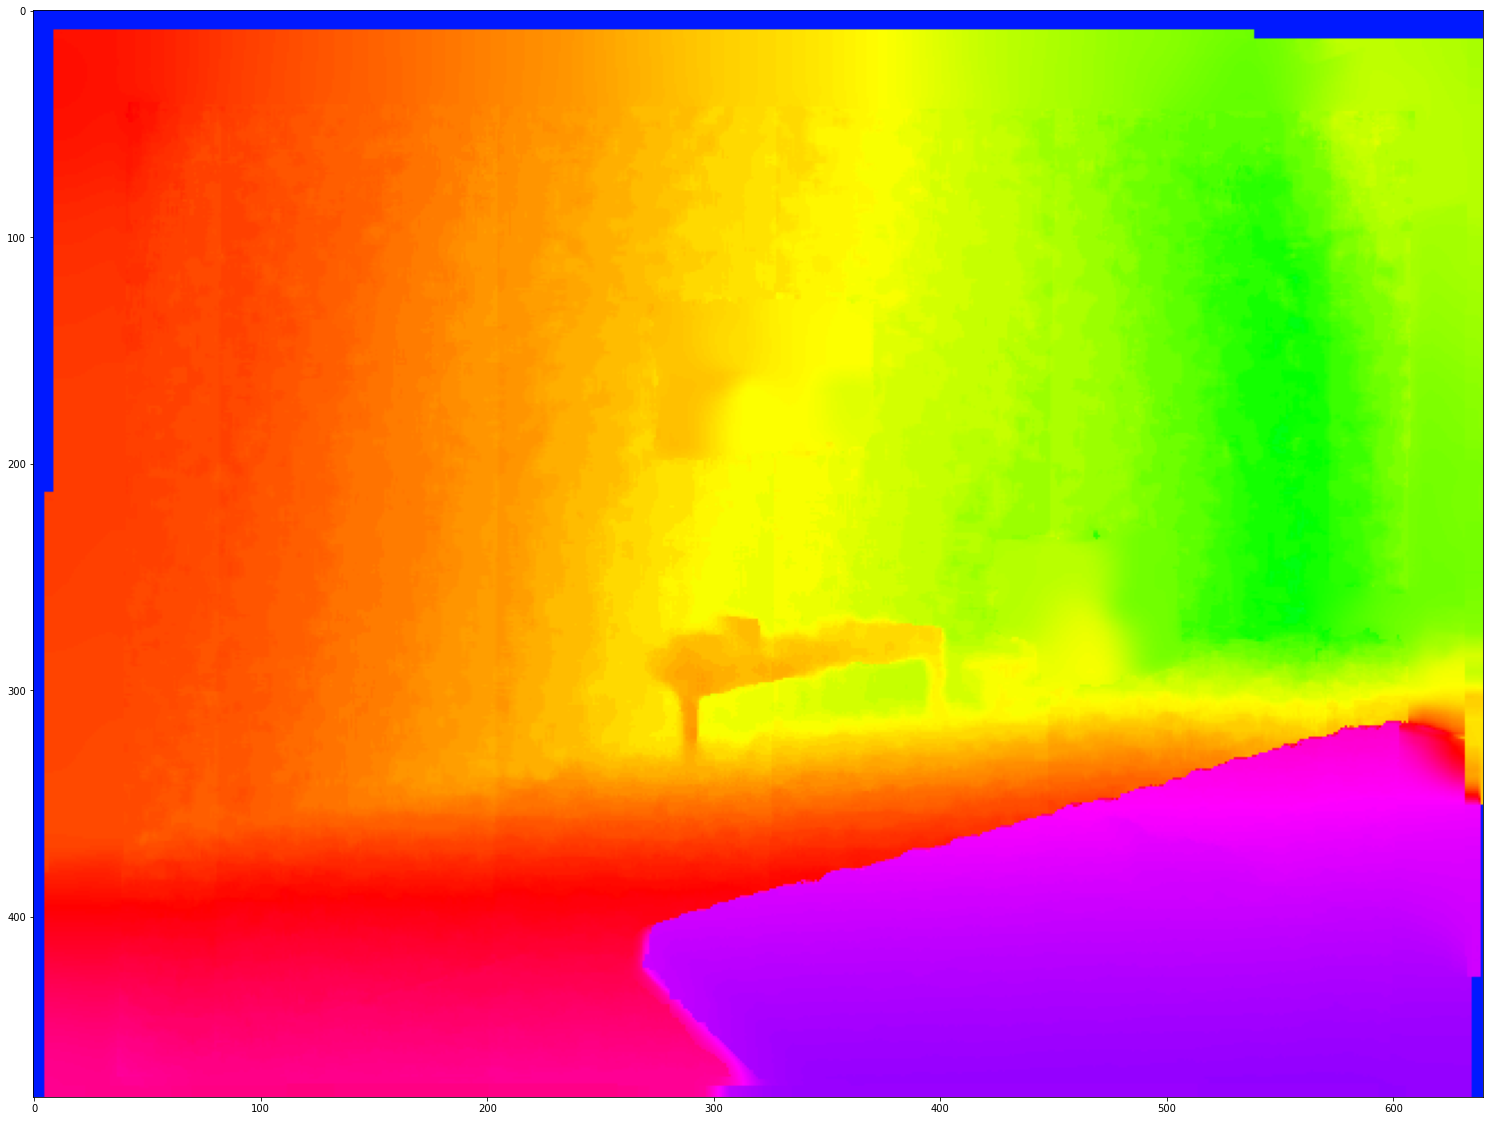

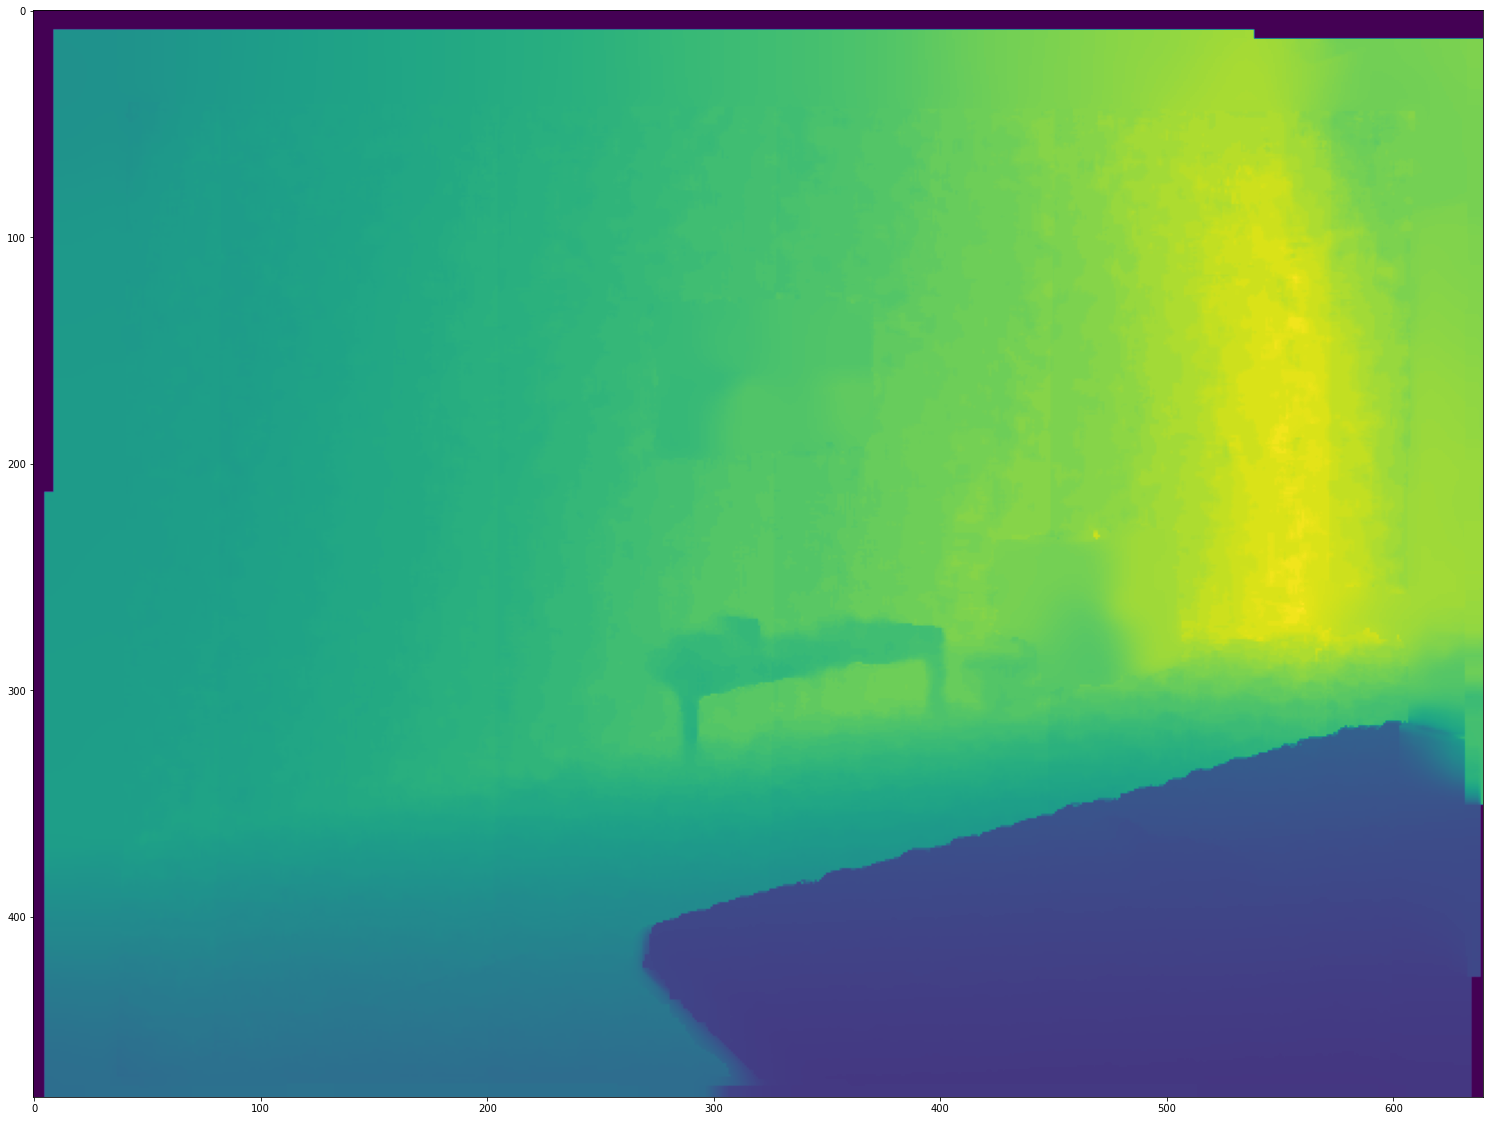

In [19]:
convertor = RGB_HSV()
# print(depth_tensor.shape)
# print(depth_tensor[:,:,1])
h = depth_tensor[:,:,:1]
starting_point = 0.65
h = (h + starting_point) % 1 
print(h.shape)
s = torch.ones_like(h) * 1
v = torch.ones_like(h) * 1

hsv_tensor = torch.cat([h, s, v], dim=2)
# print(hsv_tensor.shape)
rgb_tensor = convertor.hsv_to_rgb(hsv_tensor.permute(2, 0, 1).unsqueeze(0))

plt.figure(figsize=(30,20))
plt.imshow(rgb_tensor[0].permute(1, 2, 0))
print(rgb_tensor.shape)
hsv_tensor_recon = convertor.rgb_to_hsv(rgb_tensor)
print(hsv_tensor_recon.shape)
plt.figure(figsize=(30,20))
recon_depth = hsv_tensor_recon[0].permute(1, 2, 0)[:,:,0]
recon_depth = (h + (1 - starting_point)) % 1
plt.imshow(recon_depth)
print(recon_depth.shape)
print(depth_tensor[:,:,:1].shape)

m = torch.mean(torch.abs(recon_depth - depth_tensor[:,:,1]))

print(m)

torch.Size([1, 3, 480, 640])
tensor(4.3165e-09)


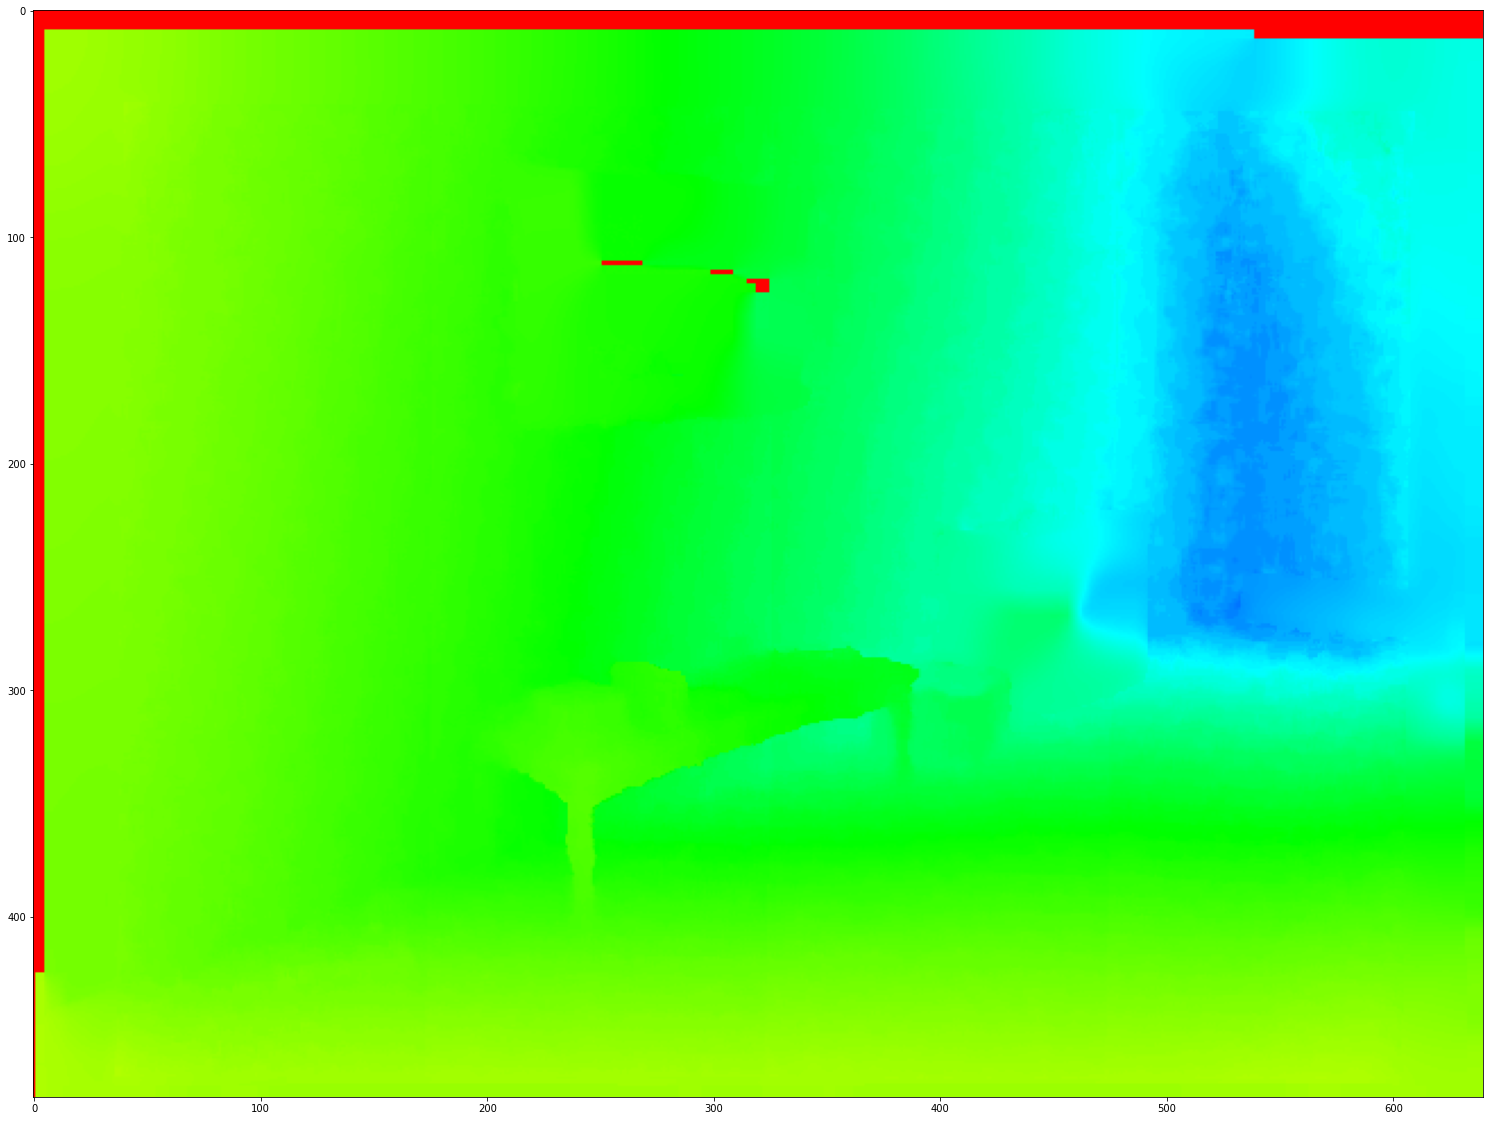

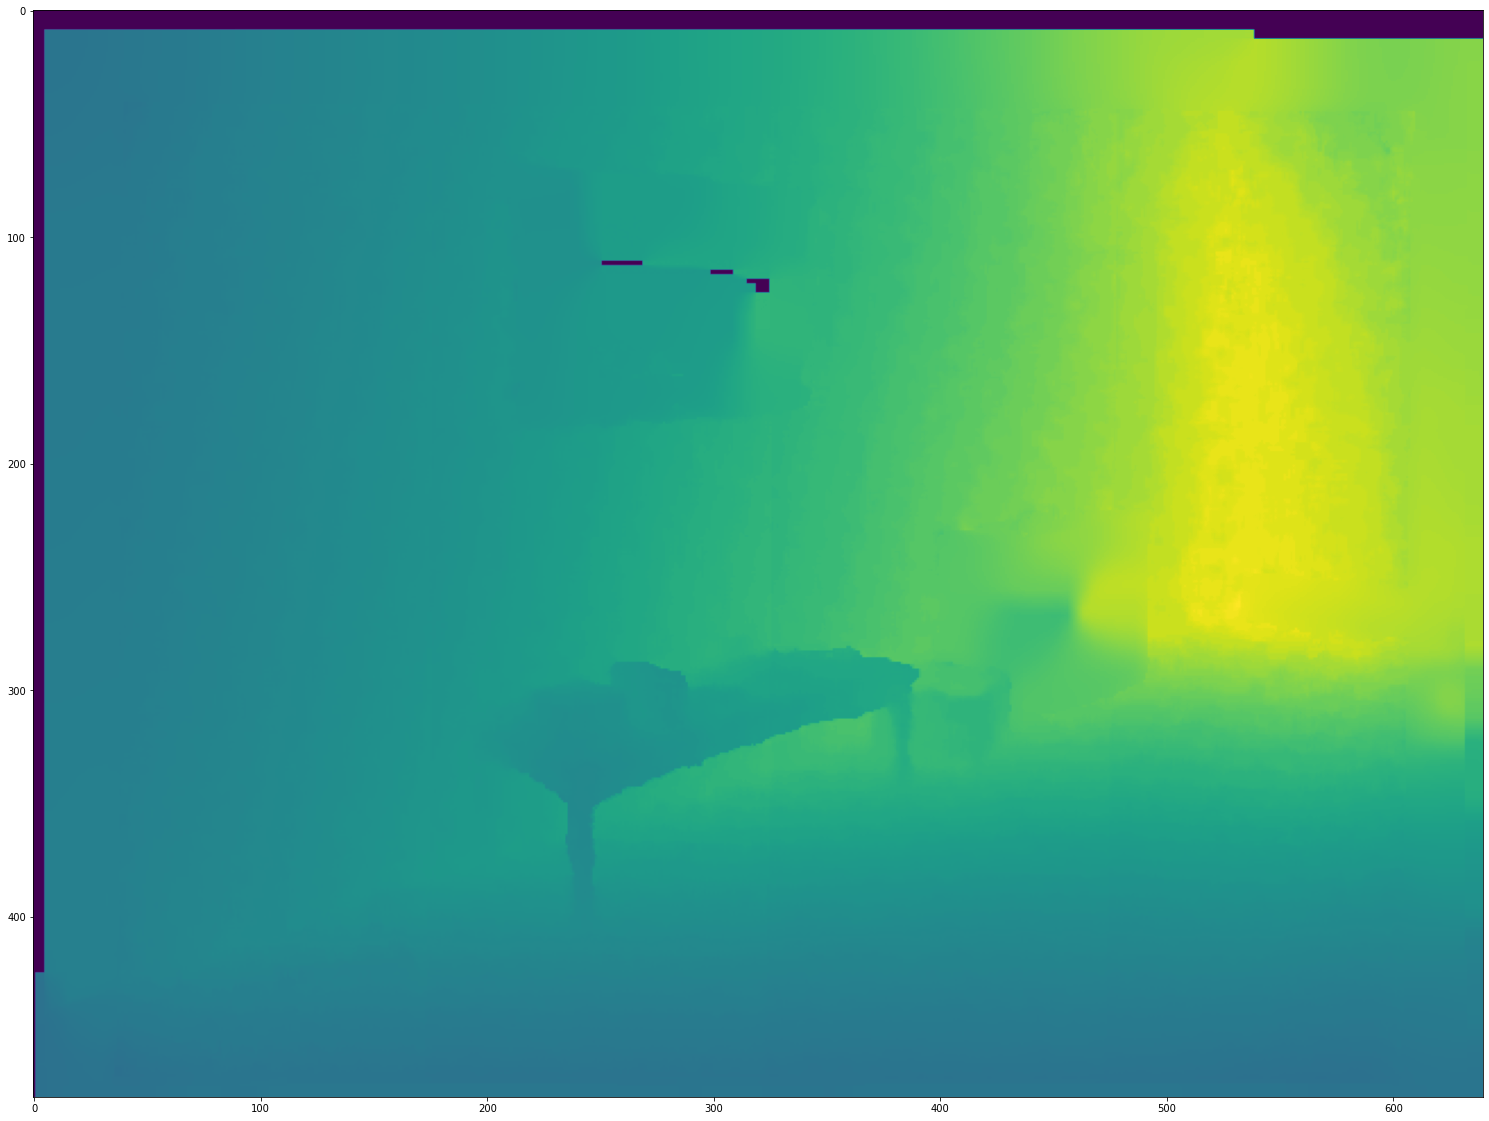

In [102]:
convertor = RGB_HSV()

h = depth_tensor[:,:,1]
s = v = torch.ones_like(h)
hsv_tensor = torch.stack([h, s, v], dim=2)


rgb_tensor = convertor.hsv_to_rgb(hsv_tensor.permute(2, 0, 1).unsqueeze(0))
print(rgb_tensor.shape)
plt.figure(figsize=(30,20))
plt.imshow(rgb_tensor[0].permute(1, 2, 0))
# print(rgb_tensor.shape)
hsv_tensor_recon = convertor.rgb_to_hsv(rgb_tensor)
# print(hsv_tensor_recon.shape)
plt.figure(figsize=(30,20))
recon_depth = hsv_tensor_recon[0].permute(1, 2, 0)[:,:,0]

plt.imshow(recon_depth)
# print(recon_depth.shape)
# print(depth_tensor[:,:,:1].shape)

m = torch.mean(torch.abs(recon_depth - depth_tensor[:,:,1]))

print(m)

In [5]:
import torch
import cv2
import matplotlib.pyplot as plt
# from rgb_hsv import RGB_HSV
import matplotlib.colors as mcolors

img = cv2.imread('../work_dirs/mask_vqseg_agg_swin_large_patch4_window12' + 
                 '_768x768_pretrain_384x384_22K_300e_cityscapes_relax_e08_hunger_non_ignore' +
                 '/show_with_pixel_pred/' +
                 'val_frankfurt_000000_009561_leftImg8bit.png')

rgb = img[:,:,::-1]  #注意opencv是BGR顺序，必须转换成RGB
rgb = rgb / 255
# print(rgb.shape)
rgb = rgb[:,:2050 * 2,:]
rgb_tensor = torch.from_numpy(rgb).permute(2,0,1).unsqueeze(0).float()
convertor = RGB_HSV()

hsv_tensor = convertor.rgb_to_hsv(rgb_tensor)
rgb1 = convertor.hsv_to_rgb(hsv_tensor)

hsv_arr = hsv_tensor[0].permute(1,2,0).numpy()
rgb1_arr = rgb1[0].permute(1,2,0).numpy()

hsv_m = mcolors.rgb_to_hsv(rgb)
rgb1_m = mcolors.hsv_to_rgb(hsv_m)



mse of my code and matplotlib: 1.0319275986113195e-15


Text(0.5, 1.0, 'visual to hsv')

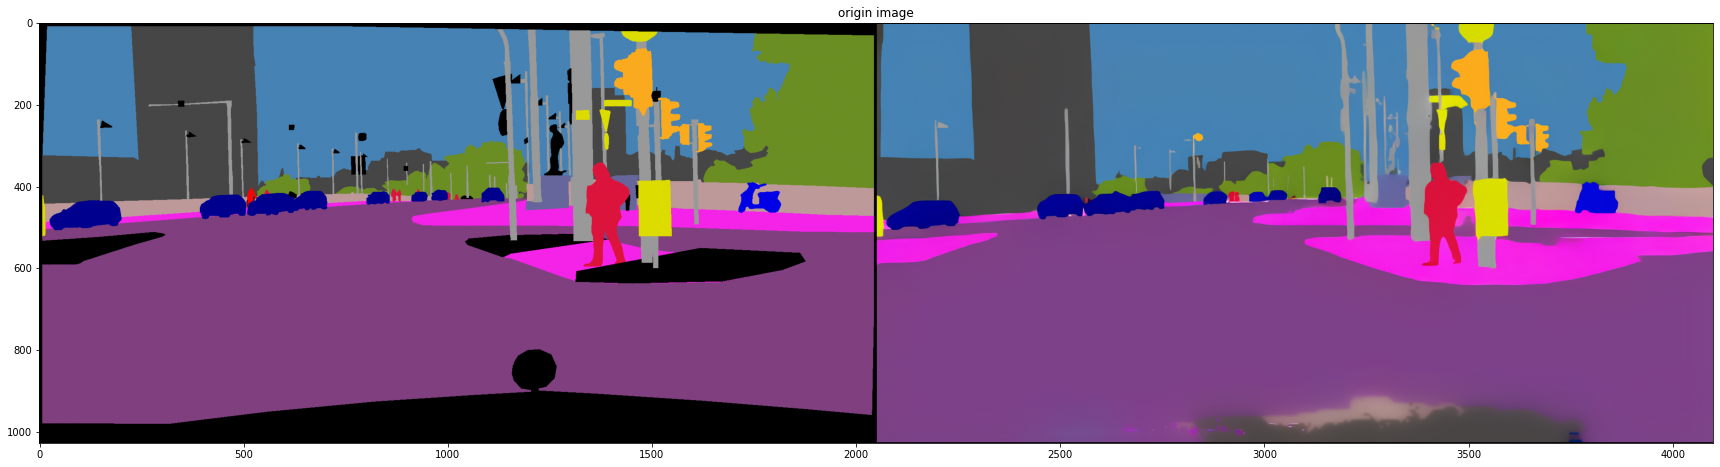

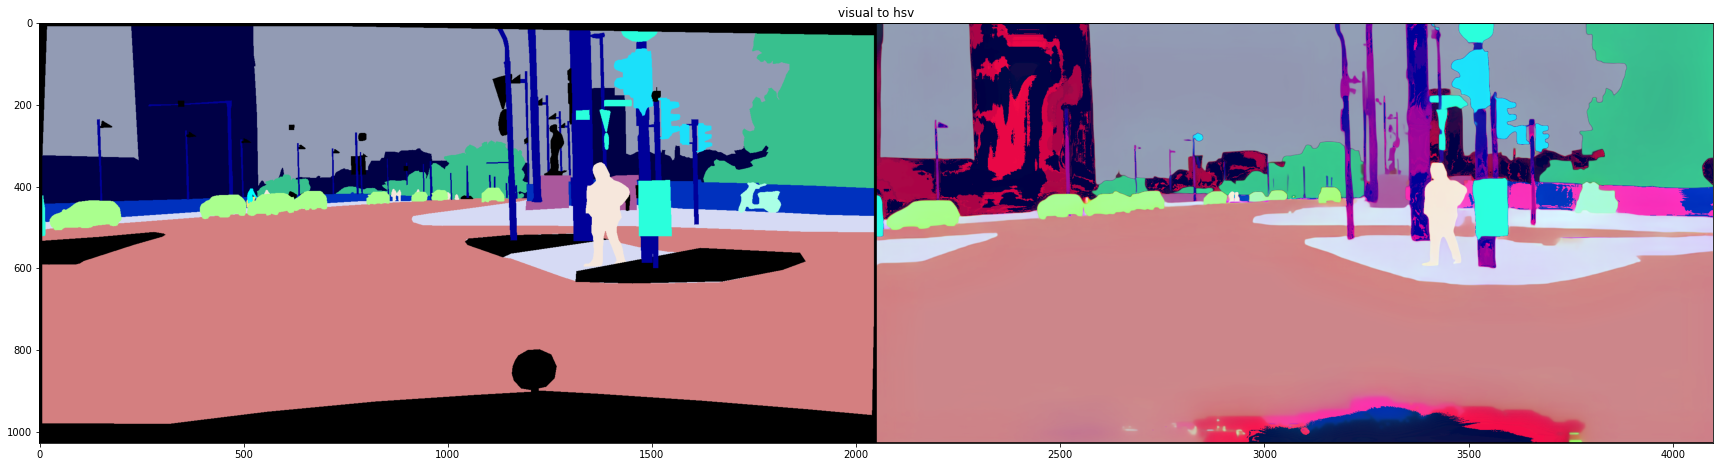

In [6]:
print('mse of my code and matplotlib:',((rgb1_arr - rgb)**2).mean())
plt.figure(figsize=(30,20))
# plt.figure()
plt.imshow(rgb)
plt.title('origin image')
plt.figure(figsize=(30,20))
plt.imshow(hsv_arr)
plt.title('visual to hsv')
# plt.figure(figsize=(30,20))
# plt.imshow(rgb1_arr)
# plt.title('convert back: my code')
# plt.figure(figsize=(30,20))
# plt.imshow(rgb1_m)
# plt.title('convert back: matplotlib method')

mse of my code and matplotlib: 1.0319275986113195e-15


Text(0.5, 1.0, 'visual to v channel')

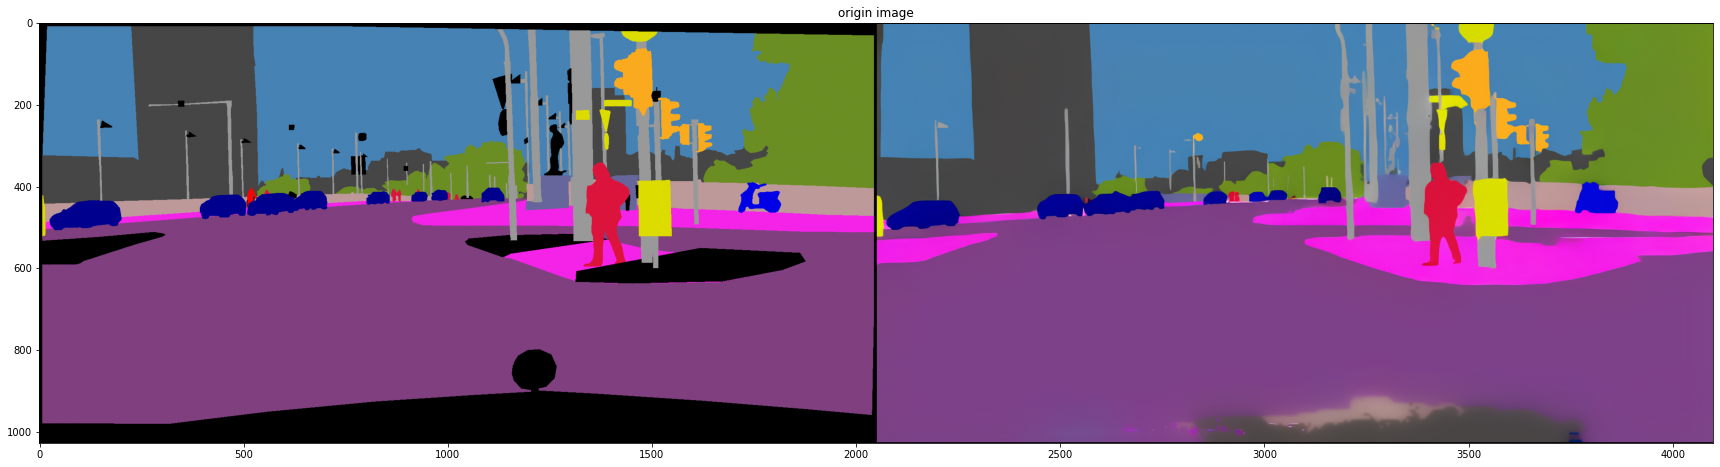

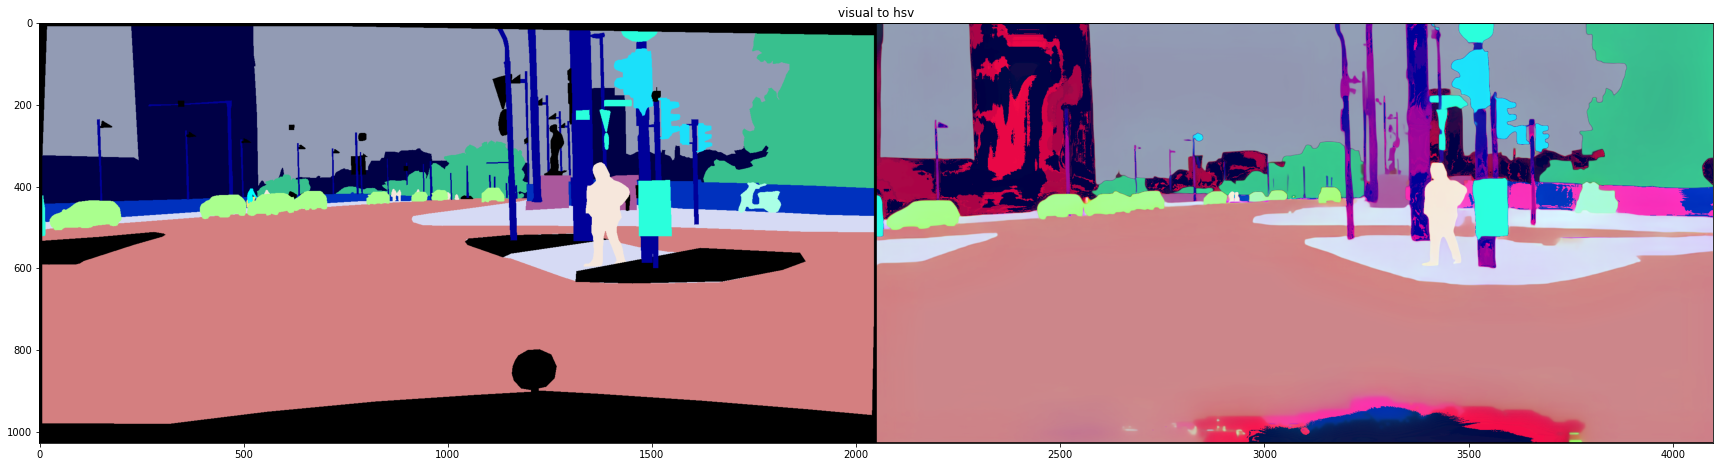

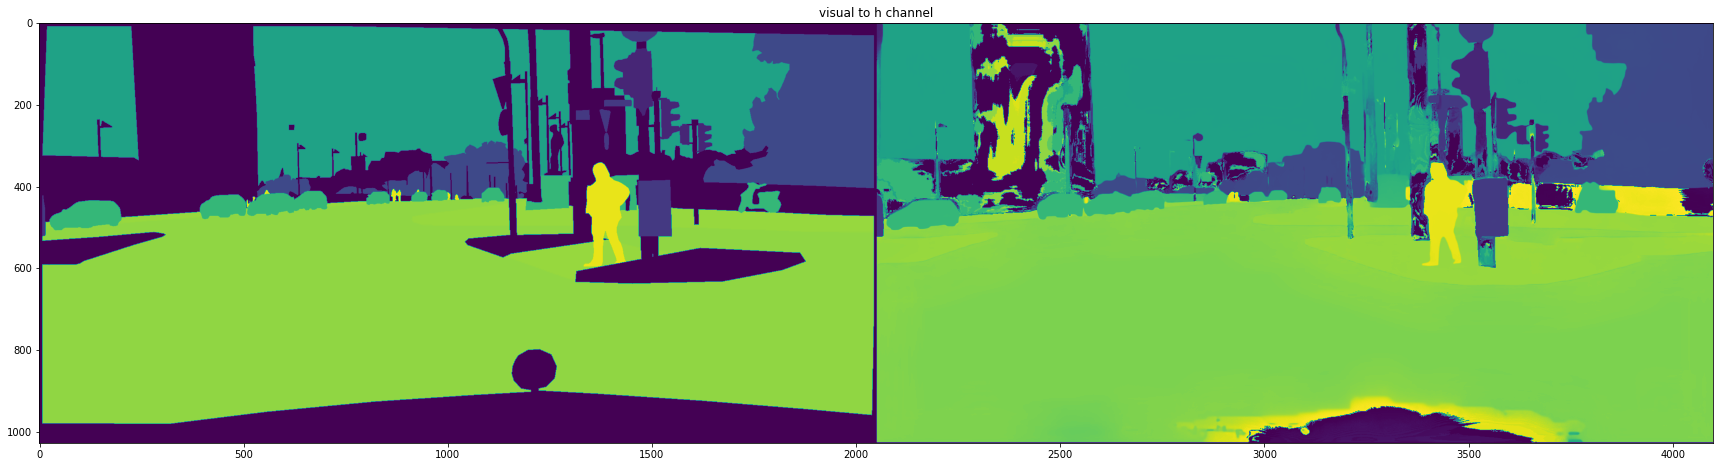

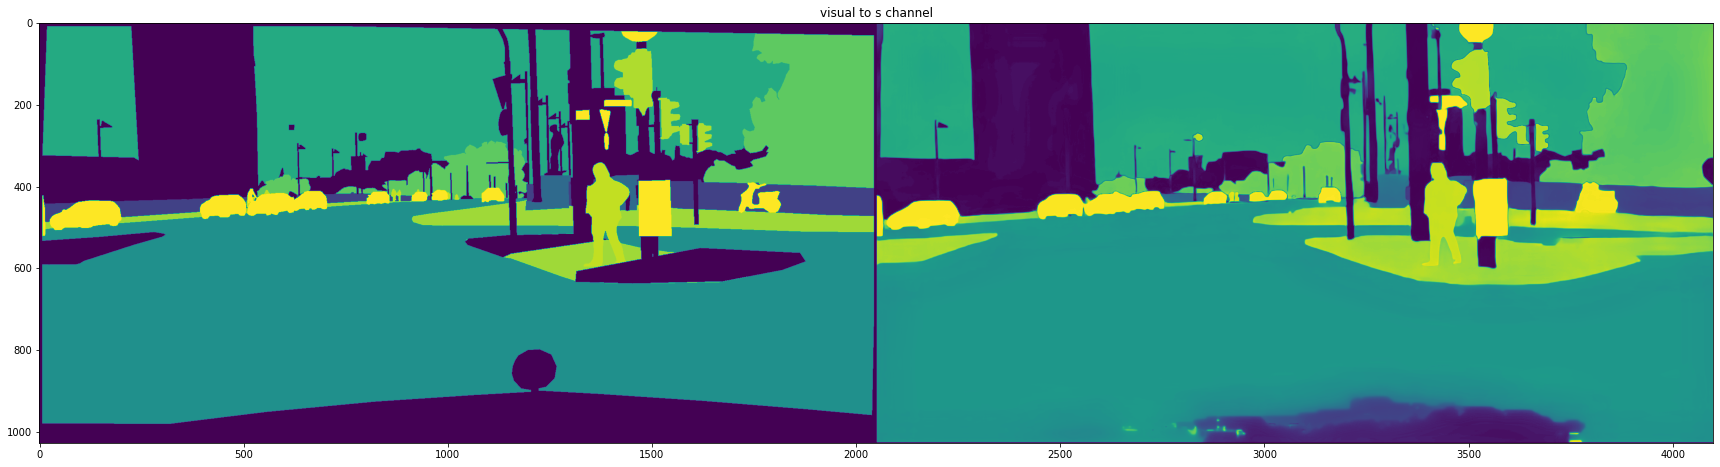

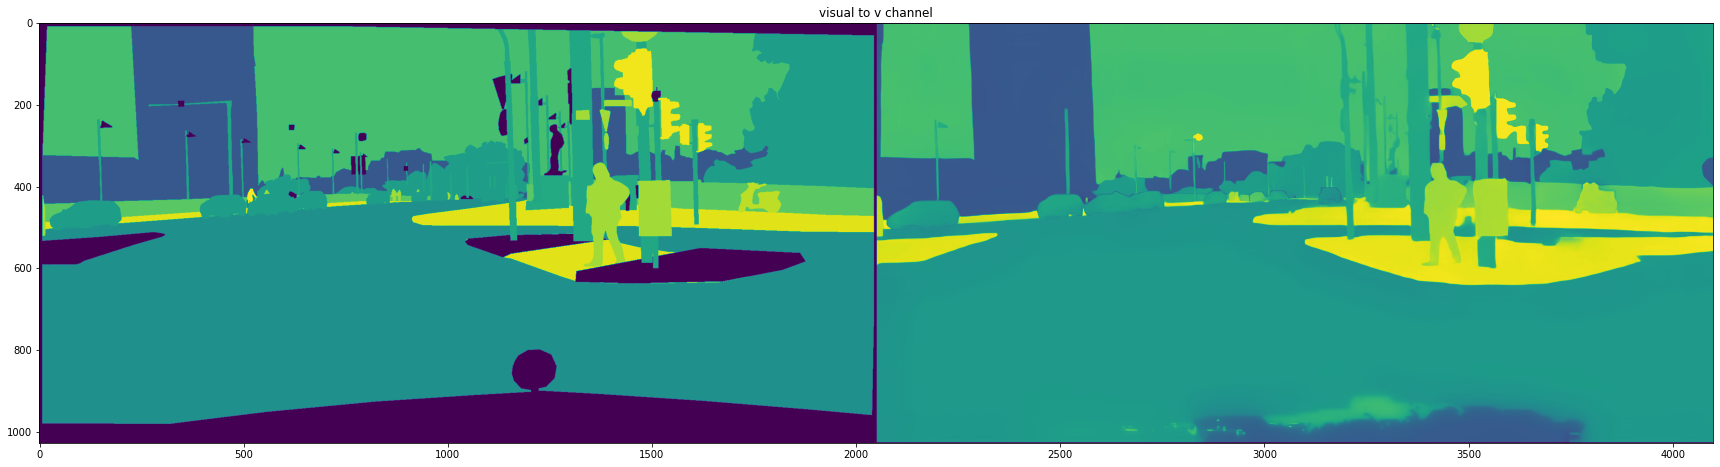

In [7]:
print('mse of my code and matplotlib:',((rgb1_arr - rgb)**2).mean())
plt.figure(figsize=(30,20))
plt.imshow(rgb)
plt.title('origin image')
plt.figure(figsize=(30,20))
plt.imshow(hsv_arr)
plt.title('visual to hsv')

plt.figure(figsize=(30,20))
plt.imshow(hsv_arr[:,:,0])
plt.title('visual to h channel')

plt.figure(figsize=(30,20))
plt.imshow(hsv_arr[:,:,1])
plt.title('visual to s channel')

plt.figure(figsize=(30,20))
plt.imshow(hsv_arr[:,:,2])
plt.title('visual to v channel')

mse of my code and matplotlib: 1.0319275986113195e-15


Text(0.5, 1.0, 'visual to B')

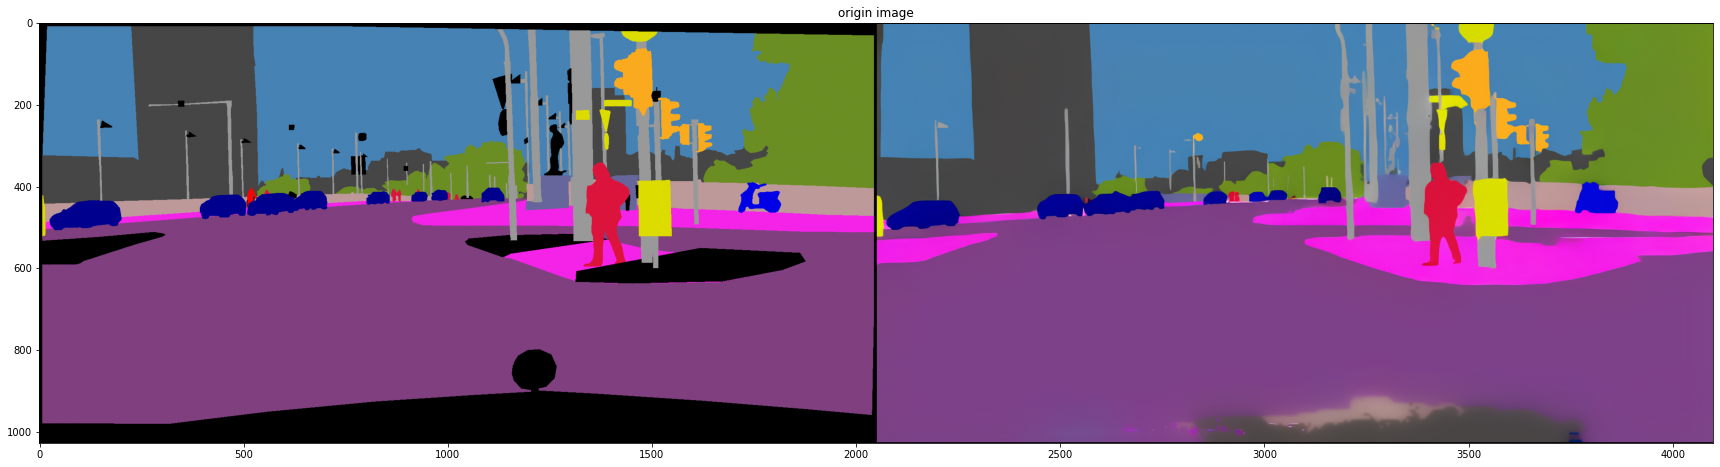

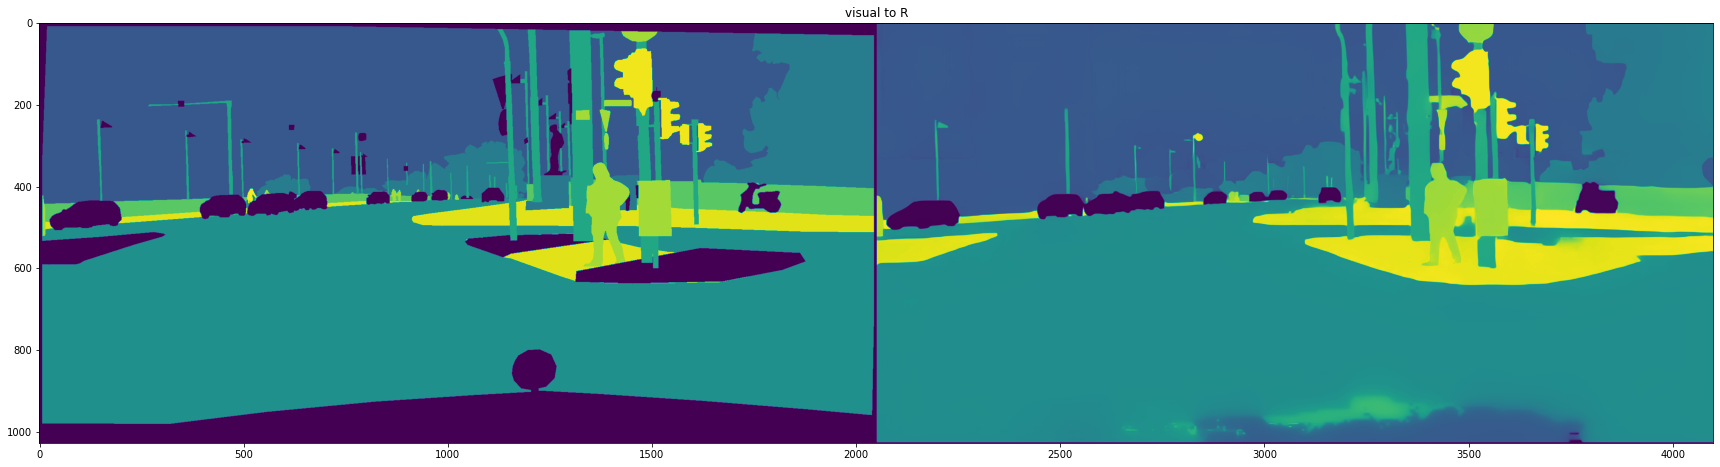

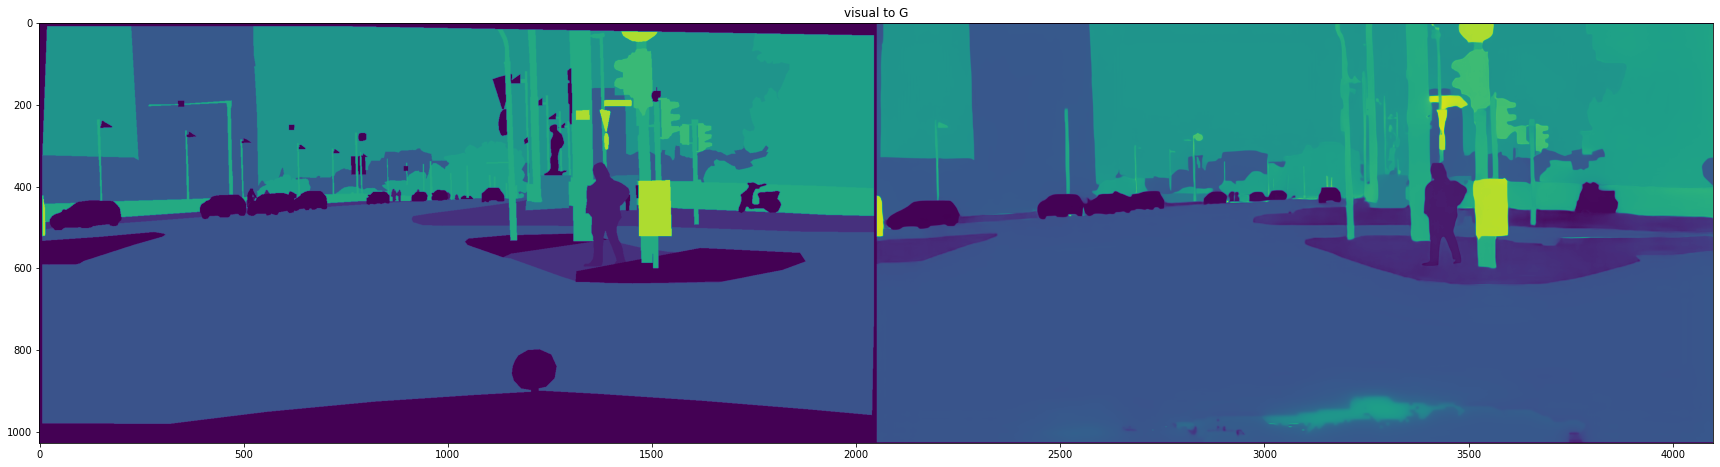

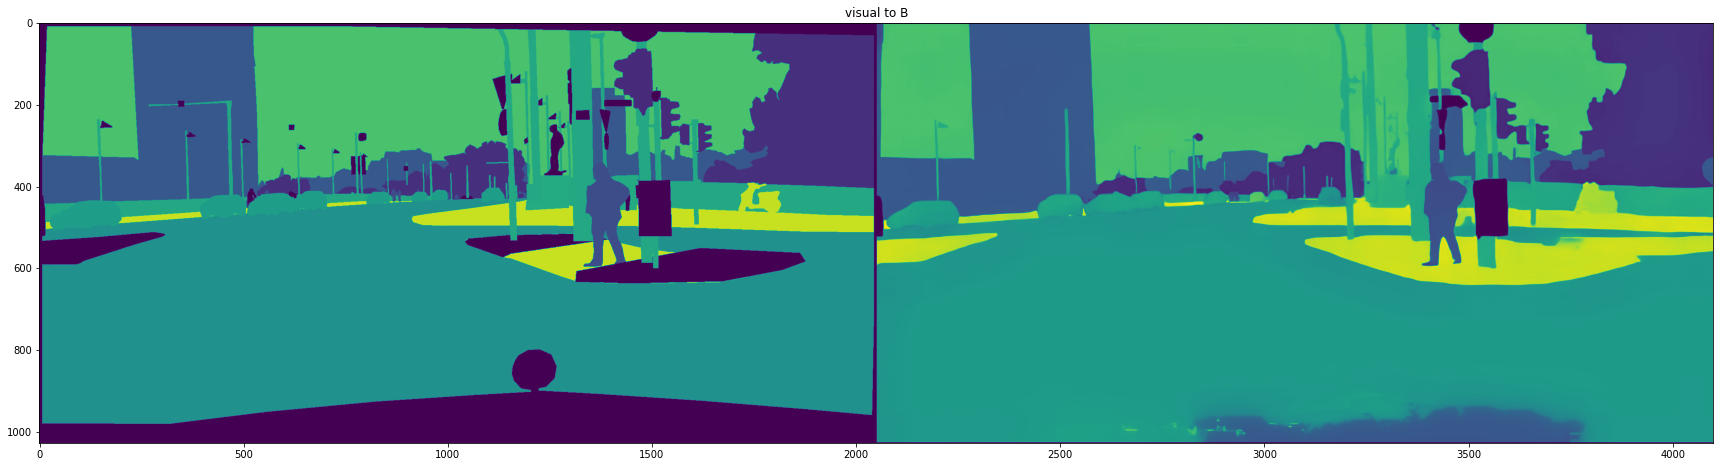

In [8]:
print('mse of my code and matplotlib:',((rgb1_arr - rgb)**2).mean())
plt.figure(figsize=(30,20))
plt.imshow(rgb)
plt.title('origin image')
plt.figure(figsize=(30,20))
plt.imshow(rgb[:,:,0])
plt.title('visual to R')

plt.figure(figsize=(30,20))
plt.imshow(rgb[:,:,1])
plt.title('visual to G')

plt.figure(figsize=(30,20))
plt.imshow(rgb[:,:,2])
plt.title('visual to B')

Text(0.5, 1.0, 'HSV image')

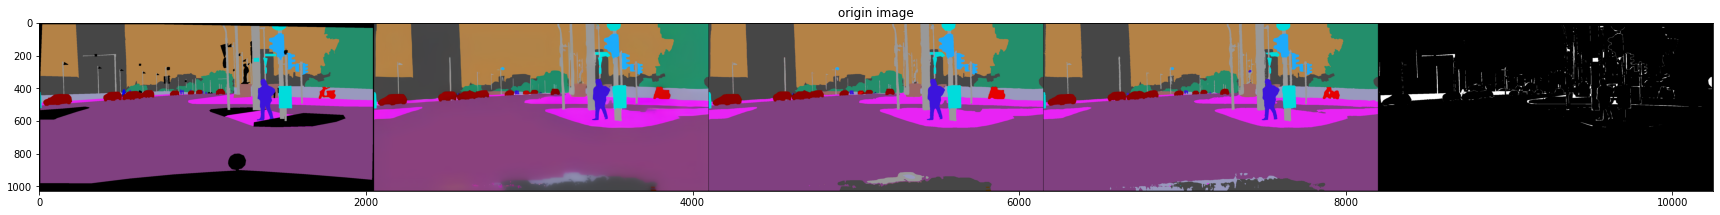

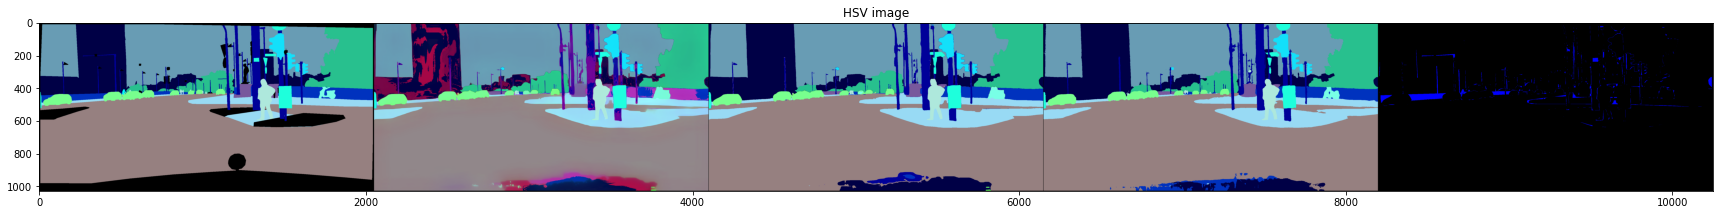

In [3]:
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(30,20))
plt.imshow(img)
plt.title('origin image')

plt.figure(figsize=(30,20))
plt.imshow(hsv_image)
plt.title('HSV image')

In [ ]:
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(30,20))
plt.imshow(img)
plt.title('origin image')

plt.figure(figsize=(30,20))
plt.imshow(hsv_image)
plt.title('HSV image')